In [17]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [18]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=17, batch_size=50):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [19]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower() + "\n"
    return str

In [20]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 93674


In [21]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'i', 'u', 's', 'h', ':', 'x', ')', 'g', ';', 'm', "'", 'a', 'p', 'l', '-', '\n', '.', 't', 'c', 'e', 'j', 'q', '?', ' ', 'b', 'v', 'y', 'z', 'n', 'k', 'd', 'o', '(', 'r', 'w', '!', 'f', ','}
# unique chars: 38


In [22]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i: i + leng])
    nxt_char.append(sons[i + leng])
print("# seqs: ", len(seqs))

# seqs:  46817


In [23]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
model = get_model((leng, len(chars)))

In [26]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 31367 samples, validate on 15450 samples
Epoch 1/17
31367/31367 [==============================] - 193s 6ms/step - loss: 2.8433 - val_loss: 2.4892
Epoch 2/17
31367/31367 [==============================] - 160s 5ms/step - loss: 2.3691 - val_loss: 2.2675
Epoch 3/17
31367/31367 [==============================] - 159s 5ms/step - loss: 2.1992 - val_loss: 2.1008
Epoch 4/17
31367/31367 [==============================] - 150s 5ms/step - loss: 2.0850 - val_loss: 2.0194
Epoch 5/17
31367/31367 [==============================] - 163s 5ms/step - loss: 2.0063 - val_loss: 1.9591
Epoch 6/17
31367/31367 [==============================] - 160s 5ms/step - loss: 1.9482 - val_loss: 1.9151
Epoch 7/17
31367/31367 [==============================] - 160s 5ms/step - loss: 1.8996 - val_loss: 1.8862
Epoch 8/17
31367/31367 [==============================] - 166s 5ms/step - loss: 1.8589 - val_loss: 1.8616
Epoch 9/17
31367/31367 [==============================] - 173s 6ms/step - loss: 1.8230 - val_loss: 1.8

In [27]:
save(model, 'models/Shakespeare_100units_17_50')

#150 units, 200 units, epochs, batch_size, dropout

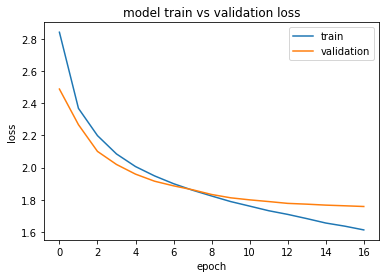

In [28]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_100units_17_50_loss.png')
pyplot.show()

In [29]:
min(history.history['val_loss'])

1.7574355409369113

In [33]:
history.history['val_loss'].index(min(history.history['val_loss']))

16

In [31]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [32]:
nchar = 800 # length of each line produced from preds
for temp in [1.5, 0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day?\n'
    sentence = line
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1

        preds = model.predict(x, verbose=False)[0]
        nxt_char = dic_id_to_char[sample(preds, temp)]

        line += nxt_char
        sentence = sentence[1:] + nxt_char
        
    print(line)



temperature = 1.5

shall i compare thee to a summer's day?
deran. o thy arl ver in uhpic blige pyeingw?
butmess grildes bring bthan at yy )ads,
then khicu ragors who tarefus living jase,
bs efe ylio vow il's from lise, biaryg'
y,
not blage afor ugo thring rewaabmab mleoved de,
not pleatashirw ig to fasd o fir,
coniaft troudue tigh, nor wrrotep, if of:.
dor whey pooe, by dowhor take ein ucaar.
unlivsh shyllrsum femflowsn, so they veeps
and,
or hakts in wuth our-vimy doth evee.
thaclever are elfrised, frau do houhts sbe.
than o ciun; no loving bad, to kindung wrelakk.
fand way no sweek bfountoto, teed, 'ucpaftiet:
i ef pyough whore drigdn thenpes iurn ry:?
lestraucey,, houg till angeh thee cworme,
whold, and seembflere am muilmed if, verlesssilids.
wyilst sucost, time i ea. sisp it verfase aured-
leavered of morey uety hevene's sfooknonce
for rlberd


temperature = 0.75

shall i compare thee to a summer's day?
for my hearth esher but to trust eyes show,
that from doth make behofe thee 